In [75]:
import os
import imp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import cvxpy as cp

from utils import spectral_analysis
from measurements import constrained_linear_measurement_operator
import matrix_sensitivities as mat_sens

## Data Management

In [76]:
def make_sens_ts(dvdp,dvdq,n=274):
    """Make timeseries of sensitivity matrices"""
    assert dvdp.shape[0] == dvdq.shape[0]
    m_tot = dvdp.shape[0] #total measurments
    m = int(m_tot/n) #Timeseries interval
    svp,svq = [],[] #timeseries list of svp and svq matrices
    for t in range(m):
        svp.append(dvdp[t*n:(t+1)*n,:])
        svq.append(dvdq[t*n:(t+1)*n,:])
    return {'svp':svp,
            'svq':svq}

def make_deviations(data):
    """Make finite differences"""
    p,q,v = data
    (dp,dq,dv) = [np.diff(x) for x in (p,q,v)]
    dx = np.vstack((dp,dq))
    return (dx,dv)

def make_S_tilde(svp,svq):
    """Make wide S_tilde matrix"""
    return np.vstack((svp.T,svq.T)).T

def make_S_0(S_tilde,pct_obs):
    """Make initial observed matrix"""
    O,_ = constrained_linear_measurement_operator(S_tilde,pct_obs)
    O,S_0 = np.asarray(O),np.multiply(np.asarray(O),S_tilde)
    return O,S_0

# Modeling Complex Power Injections in the IEEE 123-Bus Case using Voltage Sensitivities

## 1. Hourly Varying Demand, Fixed Power Factor
A constant power factor of $\alpha_i = 0.9, i = 1,\dots,n$ is applied to all loads.

In [77]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/HourlyDemand_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
sens = make_sens_ts(dvdp,dvdq)
data = make_deviations((p,q,v))
(dx,dv) = data
svp,svq = sens['svp'],sens['svq']
print(svp[0].shape,svq[0].shape,dx.shape,dv.shape)

(274, 274) (274, 274) (548, 23) (274, 23)


In [78]:
pct_obs = 0.25
S_tilde = make_S_tilde(svp[0],svq[0])
O,S_0 = make_S_0(S_tilde,pct_obs)

In [79]:
print("Relative pct. error of the 'true' sensitivity matrix: ",np.linalg.norm(dv[:,0] - S_tilde@dx[:,0])/np.linalg.norm(dv[:,0])*100)

Relative pct. error of the 'true' sensitivity matrix:  1.1973718447073551


Text(0.5, 1.0, '25% Observable Sensitivty Matrix (IEEE 123-bus)')

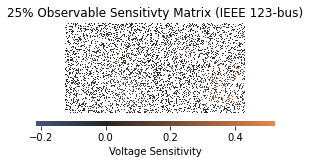

In [80]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_0),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_0)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)
ax.set_title("{pct_obs:.0f}% Observable Sensitivty Matrix (IEEE 123-bus)".format(pct_obs=pct_obs*100))

In [81]:
known_value_indices = tuple(zip(*[[0, 0], [0, 2], [1, 1], [2, 0], [2, 1]]))
known_values = [1.0, 1.9, 0.8, 3.2, 5.9]
X = np.zeros(shape=(3,3))

In [83]:
#Setup parameters
imp.reload(mat_sens)
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
lamb_.value,delta_.value = 1.25e-15,6e-3

#Solve problem
S_hat,prob = mat_sens.mat_rec_solution(S_0,dx,dv,lamb=lamb_,o=O,delta=delta_)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 05 08:33:17 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 05 08:33:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 05 08:33:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 05 08:33:17 PM: Compiling problem (target solver=DIFFCP).
(CVXPY) Apr 05 08:33:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> DIFFCP
(CVXPY) Apr 05 08:33:17 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 05 08:33:17 PM: Applying reduction CvxAttr2Constr


In [73]:
prob.derivative()

<AxesSubplot:>

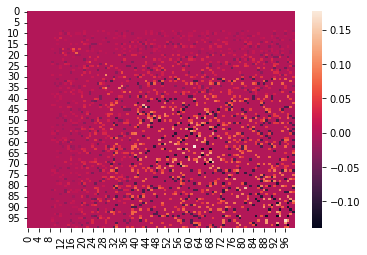

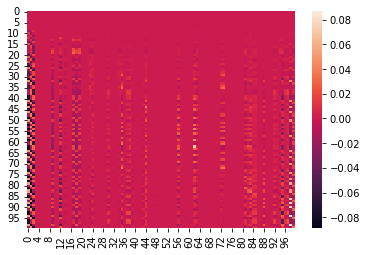

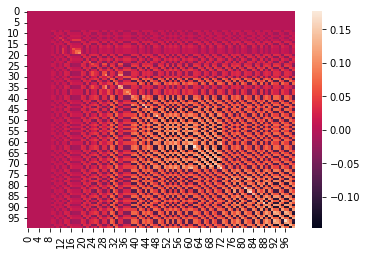

In [84]:
sns.heatmap(S_0[:100,:100])
plt.figure()
sns.heatmap(S_hat[:100,:100])
plt.figure()
sns.heatmap(S_tilde[:100,:100])

In [85]:
#rel_err_ts = [calc_rel_err(S_hat,make_S_tilde(svp_t,svq_t))*100 for svp_t,svq_t in zip(svp,svq)]

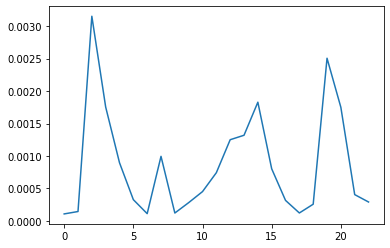

In [86]:
import utils
rel_err = []
for t,(dv_t,dx_t) in enumerate(zip(dv.T,dx.T)):
    hat_dv_t = S_hat@dx_t
    rel_err.append(utils.calc_vector_rel_err(v_est=hat_dv_t,v_true=dv_t)*100)
plt.plot(rel_err)

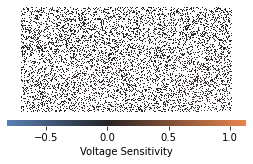

In [374]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_hat),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_hat)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)

### Plot the Spectral Analysis for the IEEE 123 Test Feeder

In [62]:
cum_sigma,normed_sigma = spectral_analysis(S_tilde)

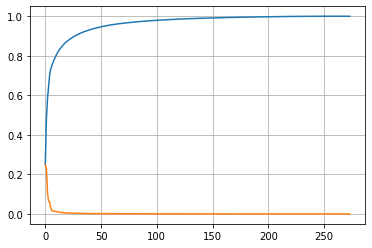

In [65]:
plt.plot(cum_sigma)
plt.plot(normed_sigma)
plt.grid()

## 2. Synthetic demands, fixed power factor 

In [ ]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
svp,svq = make_sens_ts(dvdp,dvdq)

## 3. Synthetic demands, varying power factor

In [ ]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
svp,svq = make_sens_ts(dvdp,dvdq)